In [115]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import pickle
def convertunix(columns,df=df):
    '''columns: list of column headers to convert
       df: name of df'''
    for val in columns:
        df[val] = pd.to_datetime(df[val],unit='s')
    return df
def get_num_tickets(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return sum(ticket_quant)
def get_num_tiers(val):
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    return len(ticket_quant)
def get_total_value(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    ticket_quant = []
    for i in range(len(val)):
        ticket_quant.append(val[i]['quantity_total'])
    total = 0
    for cost, quant in zip(ticket_costs, ticket_quant):
        total += cost*quant
    return total
def get_max_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return max(ticket_costs)
def get_min_ticket_cost(val):
    ticket_costs = []
    for i in range(len(val)):
        ticket_costs.append(val[i]['cost'])
    if len(ticket_costs) == 0:
        return 0
    else:
        return min(ticket_costs)
def clean_df(path_to_file):
    df=pd.read_json(path_to_file)
    df['tickets_total'] = df['ticket_types'].apply(get_num_tickets)
    df['tiers'] = df['ticket_types'].apply(get_num_tiers)
    df['max_cost'] = df['ticket_types'].apply(get_max_ticket_cost)
    df['min_cost'] = df['ticket_types'].apply(get_min_ticket_cost)
    df['total'] = df['ticket_types'].apply(get_total_value)
    df['intl_trans'] = df['country'] != df['venue_country']
    df['type_one_user'] = df['user_type'] == 1
    df['org_desc_exists'] = [0 if len(df['org_desc'][i])==0 else 1 for i in range(len(df))]
    df['org_name_exists'] = [0 if len(df['org_name'][i])==0 else 1 for i in range(len(df))]
    df['previous_payout_count'] = [len(df.previous_payouts[i]) for i in range(len(df))]
    df['org_facebook'].fillna(value=0, inplace=True)
    df['org_twitter'].fillna(value=0, inplace=True)
    df['org_facebook_exists'] = [0 if df['org_facebook'][i]==0 else 1 for i in range(len(df))]
    df['org_twitter_exists'] = [0 if df['org_twitter'][i]==0 else 1 for i in range(len(df))]
    convert = ['approx_payout_date','event_created','event_published','event_start','event_end','user_created']
    convertunix(convert,df)
    emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
    df.loc[~df["email_domain"].isin(emaillist), "email_domain"] = 0
    df.loc[df["email_domain"].isin(emaillist), "email_domain"] = 1
    countrylist = ['MA','VN','A1','PK','PH','ID','NG','CI','CZ','DZ']
    df.loc[~df["country"].isin(countrylist), "country"] = 0
    df.loc[df["country"].isin(countrylist), "country"] = 1
    df.drop(['show_map','object_id', 'name','name_length','num_order','num_payouts','org_facebook','org_twitter','payee_name','payout_type','previous_payouts','previous_payouts','org_name','org_desc','listed','fb_published','event_published','event_end','event_start','event_created','has_logo','has_header','currency','description','approx_payout_date','delivery_method','body_length','channels','gts','sale_duration', 'sale_duration2', 'ticket_types', 'user_created', 'user_type', 'venue_address', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'],axis=1,inplace=True)
    return df




#data frame used to train model
df = clean_df('../data/data.json')
df['fraud'] = df['acct_type'].str[0] == 'f'
df.drop('acct_type',axis=1,inplace=True)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                14337 non-null  object 
 1   email_domain           14337 non-null  object 
 2   has_analytics          14337 non-null  int64  
 3   user_age               14337 non-null  int64  
 4   tickets_total          14337 non-null  int64  
 5   tiers                  14337 non-null  int64  
 6   max_cost               14337 non-null  float64
 7   min_cost               14337 non-null  float64
 8   total                  14337 non-null  float64
 9   intl_trans             14337 non-null  bool   
 10  type_one_user          14337 non-null  bool   
 11  org_desc_exists        14337 non-null  int64  
 12  org_name_exists        14337 non-null  int64  
 13  previous_payout_count  14337 non-null  int64  
 14  org_facebook_exists    14337 non-null  int64  
 15  or

In [102]:

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

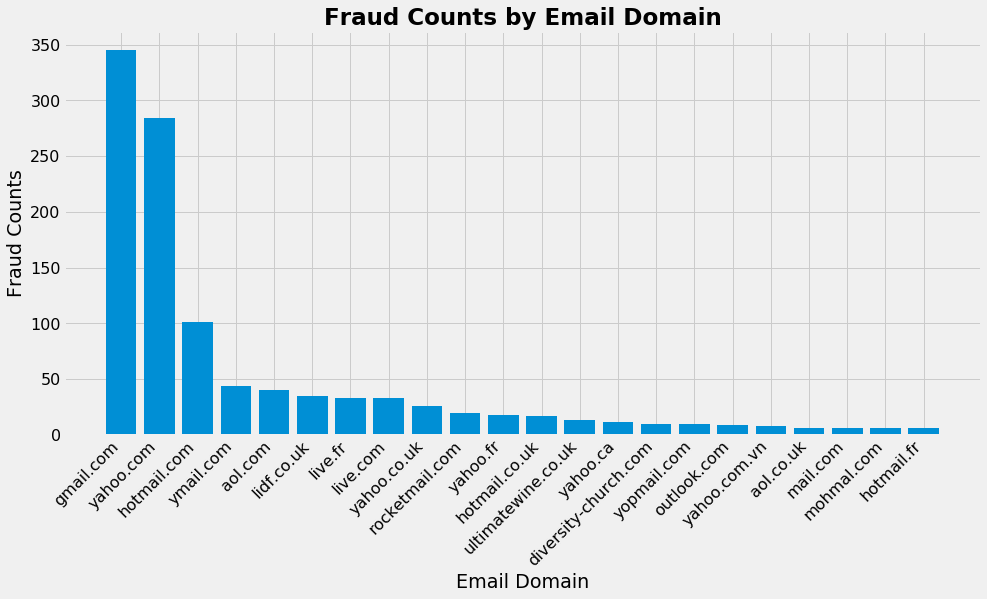

In [103]:
email = pd.concat([df['email_domain'],df['fraud']], axis=1, sort=False)
offenders = email[email['fraud']==True]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')
offenders = offenders[offenders['counts']>5]
labels=offenders['email_domain']
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(offenders['email_domain'],offenders['counts'])
ax.set_xlabel('Email Domain')
ax.set_ylabel('Fraud Counts')
ax.set_title('Fraud Counts by Email Domain',fontweight='bold')
plt.tight_layout()
plt.xticks(rotation=45,ha='right')

In [45]:
non_offenders = email[email['fraud']==False]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 <a list of 22 Text xticklabel objects>)

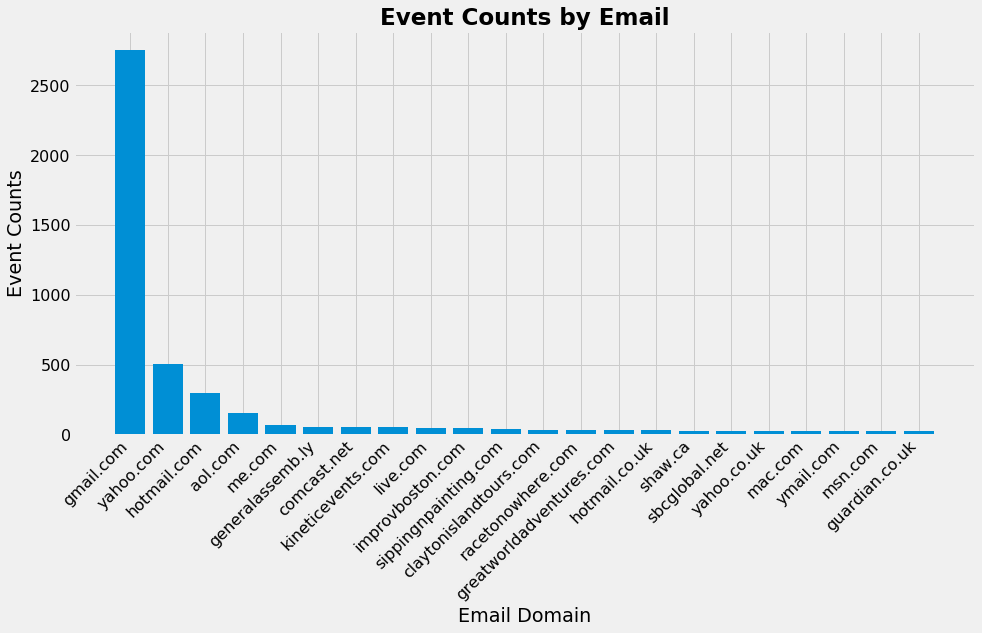

In [104]:
non_offenders = email[email['fraud']==False]['email_domain'].value_counts().rename_axis('email_domain').reset_index(name='counts')
non_offenders = non_offenders[:22]
labels=non_offenders['email_domain']
fig, ax = plt.subplots(figsize=(14,7))
ax.bar(non_offenders['email_domain'],non_offenders['counts'])
ax.set_xlabel('Email Domain')
ax.set_ylabel('Event Counts')
ax.set_title('Event Counts by Email',fontweight='bold')
plt.tight_layout()
plt.xticks(rotation=45,ha='right')

In [57]:
user_df = pd.concat([df['user_age'],df['fraud']], axis=1, sort=False)

In [65]:
user_df[user_df['user_age']==0]['fraud'].value_counts()

False    2020
True      725
Name: fraud, dtype: int64

In [119]:
df[df['country']=='US']['fraud'].value_counts()


False    8615
True      619
Name: fraud, dtype: int64

In [113]:
df[df['fraud']==True]['country'].value_counts()

1    835
0    458
Name: has_logo, dtype: int64

In [ ]:
df['country']

In [112]:
len(df)

14337

In [116]:
458/(1806+458)

0.20229681978798586

In [39]:
#Make plot
emaillist = ['ymail.com','lidf.co.uk','live.fr','rocketmail.com','yahoo.fr']
email.loc[~email["email_domain"].isin(emaillist), "email_domain"] = "Other"
email['email_domain'].value_counts()

Other             14157
ymail.com            68
lidf.co.uk           35
live.fr              33
rocketmail.com       23
yahoo.fr             21
Name: email_domain, dtype: int64

In [109]:
X=df.drop('fraud',axis=1)
y=df['fraud']

In [110]:
rf = RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [112]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
def eval_model(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print('===ACCURACY===')
    print(acc)
    print('===RECALL===')
    print(rec)
    print('===PRECISION===')
    print(prec)
    print('===F1===')
    print(f1)

In [117]:
eval_model(rf,X_test,y_test)

===ACCURACY===
0.9841004184100418
===RECALL===
0.8761609907120743
===PRECISION===
0.9433333333333334
===F1===
0.9085072231139648
